<div style="text-align: center"><h1 style="text-decoration: underline;">DSML Project</h1></div>



This is the official Notebook of the DSML Project from Marc Rennefort, Kilian Lipinsky, Timo Hagelberg, Jan Behrendt-Emden and Paul Severin. In order to create this Project we used the following dataset: https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2023-2024-/n26f-ihde/about_data
<h4 style="text-decoration: underline;">1. Description</h4>
The goal of this project is to predict ride-hailing tips in Chicago based on travel time, distance, fare amount, weather conditions, and whether the customer shared the ride.


In [1]:
#Note all your imports here

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from holoviews.plotting.plotly import ScatterPlot
from numpy.ma.core import inner
from pandas.core.common import random_state
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from meteostat import Hourly, Point
from sklearn.metrics.pairwise import euclidean_distances

<h4 style="text-decoration: underline;">2. Data Prepertion</h4>

<h4 style="text-decoration: underline;">2.1 Some Basic Data Preperation</h4>
In the first step we want to do some basic data preperartion which means that we load our data set with the columns we need, we drop all rows with null values and changing our timestamps to datetime format

In [2]:
#Loading our dataset with the columns we need
data_cleaned = pd.read_csv('Data/Chicago_RideHailing_Data.csv', usecols= ['Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Tip', 'Trip Total','Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Shared Trip Authorized', 'Shared Trip Match'])

#We can't use the Total including Tip, so we will calculate the cost (Far + other Charges) as Total - Tip
data_cleaned['Cost'] = data_cleaned['Trip Total'] - data_cleaned['Tip']
data_cleaned = data_cleaned.drop(columns=['Trip Total'])

In [3]:
#Get some basic understanding of our data
print('Null Values: ', data_cleaned.isnull().sum())
data_cleaned.info()
data_cleaned.head()

Null Values:  Trip End Timestamp                  0
Trip Seconds                     1638
Trip Miles                          1
Tip                             68110
Shared Trip Authorized              1
Shared Trip Match                   1
Dropoff Centroid Latitude     2416867
Dropoff Centroid Longitude    2416867
Cost                            68110
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27423899 entries, 0 to 27423898
Data columns (total 9 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip End Timestamp          object 
 1   Trip Seconds                float64
 2   Trip Miles                  float64
 3   Tip                         float64
 4   Shared Trip Authorized      object 
 5   Shared Trip Match           object 
 6   Dropoff Centroid Latitude   float64
 7   Dropoff Centroid Longitude  float64
 8   Cost                        float64
dtypes: float64(6), object(3)
memory usage: 1.8+ GB


,Trip End Timestamp,Trip Seconds,Trip Miles,Tip,Shared Trip Authorized,Shared Trip Match,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Cost
0,09/19/2023 07:15:00 PM,3109.0,23.5,0.0,False,False,41.893216,-87.637844,40.70
1,09/28/2023 12:45:00 PM,1640.0,14.7,0.0,False,False,41.979071,-87.903040,38.74
2,09/03/2023 05:30:00 PM,772.0,1.9,0.0,False,False,41.879255,-87.642649,22.39
3,09/13/2023 03:30:00 PM,452.0,1.1,0.0,False,False,41.892042,-87.631864,14.07
4,09/16/2023 01:00:00 PM,819.0,3.9,0.0,False,False,41.792592,-87.769615,12.89


In [4]:
#Drop all rows with null values
data_cleaned = data_cleaned.dropna(axis = 0)

In [5]:
#Changing our timestamp to datetime format
data_cleaned['Trip End Timestamp'] = pd.to_datetime(data_cleaned['Trip End Timestamp'],  format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [6]:
#Check if everything worked correctly
print('Null-Werte: ', data_cleaned.isnull().sum())
data_cleaned.info()

Null-Werte:  Trip End Timestamp            0
Trip Seconds                  0
Trip Miles                    0
Tip                           0
Shared Trip Authorized        0
Shared Trip Match             0
Dropoff Centroid Latitude     0
Dropoff Centroid Longitude    0
Cost                          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 24946147 entries, 0 to 27423897
Data columns (total 9 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip End Timestamp          datetime64[ns]
 1   Trip Seconds                float64       
 2   Trip Miles                  float64       
 3   Tip                         float64       
 4   Shared Trip Authorized      object        
 5   Shared Trip Match           object        
 6   Dropoff Centroid Latitude   float64       
 7   Dropoff Centroid Longitude  float64       
 8   Cost                        float64       
dtypes: datetime64[ns](1), float64(6), object(2)


<h4 style="text-decoration: underline;">2.2 Including weather data</h4>
In order to add the weather data we need to group our data because otherwise we will get runtime issues if we do API calls for barely 25 Million rows. This should be fine for our prediction purposes because there won't be huge differences in temperature or rain if we round by the second decimal place

In [7]:
#Round the Latitude and Longitude by the second decimal place and insert it in a new column
data_cleaned["Latitude rounded"] =  data_cleaned["Dropoff Centroid Latitude"].round(2)
data_cleaned["Longitude rounded"] = data_cleaned["Dropoff Centroid Longitude"].round(2)

#Group the data by Latitude and Longitude
data_grouped = data_cleaned.groupby(["Latitude rounded", "Longitude rounded"])["Trip End Timestamp"].agg(["min", "max"]).reset_index()
data_grouped.head()

,Latitude rounded,Longitude rounded,min,max
0,41.65,-87.60,2023-08-31 01:00:00,2024-04-28 23:30:00
1,41.65,-87.56,2023-08-31 12:45:00,2024-03-29 07:45:00
2,41.66,-87.65,2023-08-31 08:30:00,2024-03-30 21:30:00
3,41.66,-87.64,2023-08-31 02:00:00,2024-04-28 13:15:00
4,41.66,-87.60,2023-08-31 00:00:00,2024-04-26 08:30:00


In [8]:
weather_list = []
for i in range(len(data_grouped)):
    #Initalise variables
    latitude = data_grouped["Latitude rounded"].iloc[i]
    longitude = data_grouped["Longitude rounded"].iloc[i]
    location = Point(latitude, longitude)
    timestamp_min = data_grouped["min"].iloc[i]
    timestamp_max = data_grouped["max"].iloc[i]
    
    #Round min and max column to the next hour in order to extract the weather data correctly
    timestamp_min_rounded = timestamp_min.replace(minute = 0, second = 0) 
    timestamp_max_rounded = timestamp_max.replace(minute = 0, second = 0)
    
    #Extract the weather data per location
    weather = Hourly(location, timestamp_min_rounded, timestamp_max_rounded).fetch()

    #Merge the extracted weather data with the fitting timestamps and locations
    for j in range(len(weather)):
       weather_list.append({"Timestamp": weather.index[j], "Latitude rounded": latitude, "Longitude rounded": longitude, "Temperature": weather["temp"].iloc[j], "Rain in mm": weather["prcp"].iloc[j]})

#Covert the list to a DataFrame
weather_data = pd.DataFrame(weather_list)
weather_data.head()

,Timestamp,Latitude rounded,Longitude rounded,Temperature,Rain in mm
0,2023-08-31 01:00:00,41.65,-87.6,16.1,0.0
1,2023-08-31 02:00:00,41.65,-87.6,15.8,0.0
2,2023-08-31 03:00:00,41.65,-87.6,15.6,0.0
3,2023-08-31 04:00:00,41.65,-87.6,15.2,0.0
4,2023-08-31 05:00:00,41.65,-87.6,14.5,0.0


In [9]:
#Now we prepare the merge of the weather data and the other data. For this we need to round our timestamps by the next hour because our weather data is given hourly
data_cleaned["Trip End Timestamp Rounded"] = data_cleaned["Trip End Timestamp"].dt.floor("h")


In [10]:
#In the next step we can start with the merge
data_merged = pd.merge(data_cleaned, weather_data, left_on=["Trip End Timestamp Rounded", "Latitude rounded", "Longitude rounded"], right_on =["Timestamp", "Latitude rounded", "Longitude rounded"], how = "inner")

In [11]:
#After that we can drop all the columns we just needed to merge our data
data_merged = data_merged.drop(columns = ["Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Latitude rounded", "Longitude rounded", "Timestamp" ,"Trip End Timestamp Rounded"])
data_merged.head()

,Trip End Timestamp,Trip Seconds,Trip Miles,Tip,Shared Trip Authorized,Shared Trip Match,Cost,Temperature,Rain in mm
0,2023-09-19 19:15:00,3109.0,23.5,0.0,False,False,40.70,16.7,0.3
1,2023-09-28 12:45:00,1640.0,14.7,0.0,False,False,38.74,18.9,0.0
2,2023-09-03 17:30:00,772.0,1.9,0.0,False,False,22.39,31.1,0.0
3,2023-09-13 15:30:00,452.0,1.1,0.0,False,False,14.07,17.8,0.0
4,2023-09-16 13:00:00,819.0,3.9,0.0,False,False,12.89,16.1,0.0


<h4 style="text-decoration: underline;">2.3 Creation of dummy variables</h4>
To perform or regression later on we need to transfer the 'Shared Trip Authorized', 'Shared Trip Match' and 'Trip End Timestamp' column to numeric datatype. For this we make use of dummy variable where 1 stands for true and 0 stands for false for the Shared Trip variables and different variables for the time of day in case of the Trip End variable. In addition we need to creat dummy variables for the rain because we are not interested in the amount of rain on a certain day rather we want to plot wheter it rained or not. 

In [12]:
#Create dummy variable for 'Shared Trip Authorized' and 'Shared Trip Match' (1 = True and 0 = False)
data_merged["Shared Trip Authorized"] = data_merged["Shared Trip Authorized"].astype(int)
data_merged["Shared Trip Match"] = data_merged["Shared Trip Match"].astype(int)
print("📋First 5 Rows:")
data_merged.head()


📋First 5 Rows:


,Trip End Timestamp,Trip Seconds,Trip Miles,Tip,Shared Trip Authorized,Shared Trip Match,Cost,Temperature,Rain in mm
0,2023-09-19 19:15:00,3109.0,23.5,0.0,0,0,40.70,16.7,0.3
1,2023-09-28 12:45:00,1640.0,14.7,0.0,0,0,38.74,18.9,0.0
2,2023-09-03 17:30:00,772.0,1.9,0.0,0,0,22.39,31.1,0.0
3,2023-09-13 15:30:00,452.0,1.1,0.0,0,0,14.07,17.8,0.0
4,2023-09-16 13:00:00,819.0,3.9,0.0,0,0,12.89,16.1,0.0


In [13]:
#Create dummy variables for the Trip End Timestamp: 22:00-6:00 for night, 6:00-18:00 for day and 18:00-22:00 for evening
data_merged["Trip End Hour"] = data_merged["Trip End Timestamp"].dt.hour
data_merged["Night"] = np.where((data_merged["Trip End Hour"] >= 22) | (data_merged["Trip End Hour"] < 6), 1, 0)
data_merged["Day"] = np.where((data_merged["Trip End Hour"] >= 6) & (data_merged["Trip End Hour"] < 18), 1, 0)
data_merged["Evening"] = np.where((data_merged["Trip End Hour"] >= 18) & (data_merged["Trip End Hour"] < 22), 1, 0)
#Drop the Trip End Hour & Trip End Timestamp column as we don't need them anymore
data_merged = data_merged.drop(columns=["Trip End Hour", "Trip End Timestamp"])

data_merged.head()

,Trip Seconds,Trip Miles,Tip,Shared Trip Authorized,Shared Trip Match,Cost,Temperature,Rain in mm,Night,Day,Evening
0,3109.0,23.5,0.0,0,0,40.70,16.7,0.3,0,0,1
1,1640.0,14.7,0.0,0,0,38.74,18.9,0.0,0,1,0
2,772.0,1.9,0.0,0,0,22.39,31.1,0.0,0,1,0
3,452.0,1.1,0.0,0,0,14.07,17.8,0.0,0,1,0
4,819.0,3.9,0.0,0,0,12.89,16.1,0.0,0,1,0


In [14]:
#We see that the column 'Rain in mm' is from datatype object but we need a numeric datatype, so we need to transform this column to the right datatype
data_merged['Rain in mm'] = pd.to_numeric(data_merged['Rain in mm'], errors='coerce')

In [15]:
#Switching the columns so that all dummy variables will be after all numeric variables
data_merged = data_merged[['Tip', 'Trip Seconds', 'Trip Miles', 'Cost', 'Temperature', 'Rain in mm', 'Shared Trip Authorized', 'Shared Trip Match', 'Day', 'Evening', 'Night']]

<h4 style="text-decoration: underline;">2.4 Dealing with outliers</h4>
Outliers are often caused by errors in data collection. Therefore it is important to identify and remove them as they can distort the performance of predictive models by representing values that do not reflect typical or real-world scenarios. In the following we attempted to remove outliers using the standard deviation method. However, it must be acknowledged that we cannot say with complete certainty whether each detected outlier represents a data collection error or simply reflects rare but valid cases—since we did not collect the data ourselves. Nevertheless this approach helps us prepare the dataset as effectively as possible for building robust predictive models
 

In [16]:

#We don't need to deal with outliers on the columns with dummy variables because there can't be outliers if we just have the values 0 or 1
data_merged_without_tip = data_merged.drop(columns = ["Tip", "Shared Trip Authorized", "Shared Trip Match", "Night", "Day", "Evening"])
for columns in data_merged_without_tip.columns:
    #Calculate mean and standard deviation of the current column
    mean = data_merged_without_tip[columns].mean()
    std = data_merged_without_tip[columns].std()
    
    #Calculate upper and lower limit
    upperlimit = mean + 3 * std
    lowerlimit = mean - 3 * std

    #Replace all outliers with null values so we can remove them later
    data_merged.loc[(data_merged[columns] > upperlimit) | (data_merged[columns] < lowerlimit), columns] = np.nan

#Remove all null values (delete all outliers)    
data_without_outliers = data_merged.dropna(axis = 0)
print(f"❌ Deleted {len(data_merged) - len(data_without_outliers)} outliers")

data_without_outliers.head()


❌ Deleted 2101674 outliers


,Tip,Trip Seconds,Trip Miles,Cost,Temperature,Rain in mm,Shared Trip Authorized,Shared Trip Match,Day,Evening,Night
0,0.0,3109.0,23.5,40.70,16.7,0.3,0,0,0,1,0
1,0.0,1640.0,14.7,38.74,18.9,0.0,0,0,1,0,0
2,0.0,772.0,1.9,22.39,31.1,0.0,0,0,1,0,0
3,0.0,452.0,1.1,14.07,17.8,0.0,0,0,1,0,0
4,0.0,819.0,3.9,12.89,16.1,0.0,0,0,1,0,0


<h4 style="text-decoration: underline;">2.5 Saving the data</h4>
We will save the preperated data here, so that we can continue working with it, without having to rerun all the code above every time we start.

In [17]:
data_without_outliers.to_csv('Data/Chicago_RideHailing_Data_Cleaned.csv', index=False)

<h4 style="text-decoration: underline;">3. Data Modeling</h4>
First, we can load the saved data, if we didn't rerun the code above.

In [2]:
data_without_outliers = pd.read_csv('Data/Chicago_RideHailing_Data_Cleaned.csv')
#Check if everything worked correctly
data_without_outliers.head()

,Tip,Trip Seconds,Trip Miles,Cost,Temperature,Rain in mm,Shared Trip Authorized,Shared Trip Match,Day,Evening,Night
0,0.0,3109.0,23.5,40.70,16.7,0.3,0,0,0,1,0
1,0.0,1640.0,14.7,38.74,18.9,0.0,0,0,1,0,0
2,0.0,772.0,1.9,22.39,31.1,0.0,0,0,1,0,0
3,0.0,452.0,1.1,14.07,17.8,0.0,0,0,1,0,0
4,0.0,819.0,3.9,12.89,16.1,0.0,0,0,1,0,0


First of all we need to split our data in train, test and validation data.

In [3]:
#Define x and y vectors
x = data_without_outliers.drop(columns = ["Tip"])
y = data_without_outliers["Tip"]

#Perform train test validation split
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(x, y, test_size = 0.5, random_state = 42)
x_val_data, x_test_data, y_val_data, y_test_data = train_test_split(x_test_data, y_test_data, test_size = 0.6, random_state = 42)
print("Datasplit:")
print(f"🏋️ Training: {len(x_train_data)} Samples ({len(x_train_data)/len(data_without_outliers)*100:.1f}%)")
print(f"🔬 Testing: {len(x_test_data)} Samples ({len(x_test_data)/len(data_without_outliers)*100:.1f}%)")
print(f"✅ Validation: {len(x_val_data)} Samples ({len(x_val_data)/len(data_without_outliers)*100:.1f}%)")

Datasplit:
🏋️ Training: 11422236 Samples (50.0%)
🔬 Testing: 6853343 Samples (30.0%)
✅ Validation: 4568894 Samples (20.0%)


Now we will look at key statistics about our data. We only use the training data for this, in order to rule out accidental data leakage.

In [20]:
#Create a table with a column for each feature and key statistics as rows
def create_statistics_table(df):
    stats = pd.DataFrame(index=['Mean', 'Median', 'Standard Deviation', 'Min', 'Max', 'Range'])
    for column in df.columns:
        stats[column] = [
            df[column].mean(),
            df[column].median(),
            df[column].std(),
            df[column].min(),
            df[column].max(),
            df[column].max() - df[column].min()
        ]
    return stats

#Create statistics table for the training data
features_stats_table = create_statistics_table(x_train_data)
target_stats_table = create_statistics_table(y_train_data.to_frame(name='Tip'))
stats_table = pd.concat([target_stats_table.rename(columns={'Tip': 'Tip (Target)'}), features_stats_table], axis=1)
stats_table.head(len(stats_table))

,Tip (Target),Trip Seconds,Trip Miles,Cost,Temperature,Rain in mm,Shared Trip Authorized,Shared Trip Match,Day,Evening,Night
Mean,1.029833,964.090454,5.299460,17.648573,9.464874,0.056853,0.054922,0.023157,0.529926,0.253529,0.216545
Median,0.000000,813.000000,3.500000,14.820000,8.300000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Standard Deviation,2.236497,606.986064,4.920317,10.281128,8.432149,0.191103,0.227828,0.150401,0.499104,0.435031,0.411890
Min,0.000000,0.000000,0.000000,0.000000,-17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Max,100.000000,3315.000000,25.200000,60.140000,33.900000,1.400000,1.000000,1.000000,1.000000,1.000000,1.000000
Range,100.000000,3315.000000,25.200000,60.140000,50.900000,1.400000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's plot the data to get an first overview on our predictors.

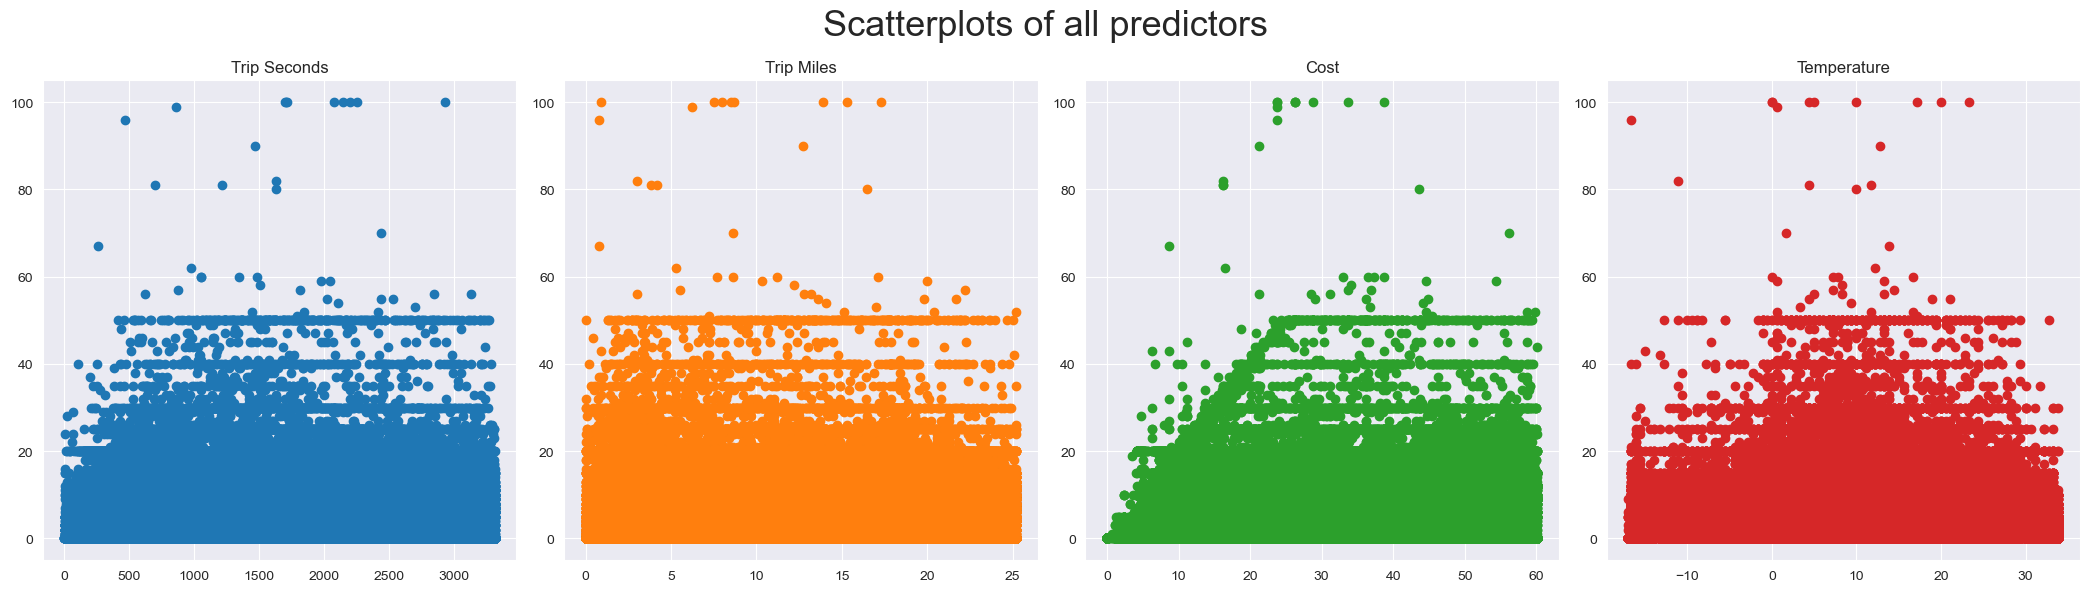

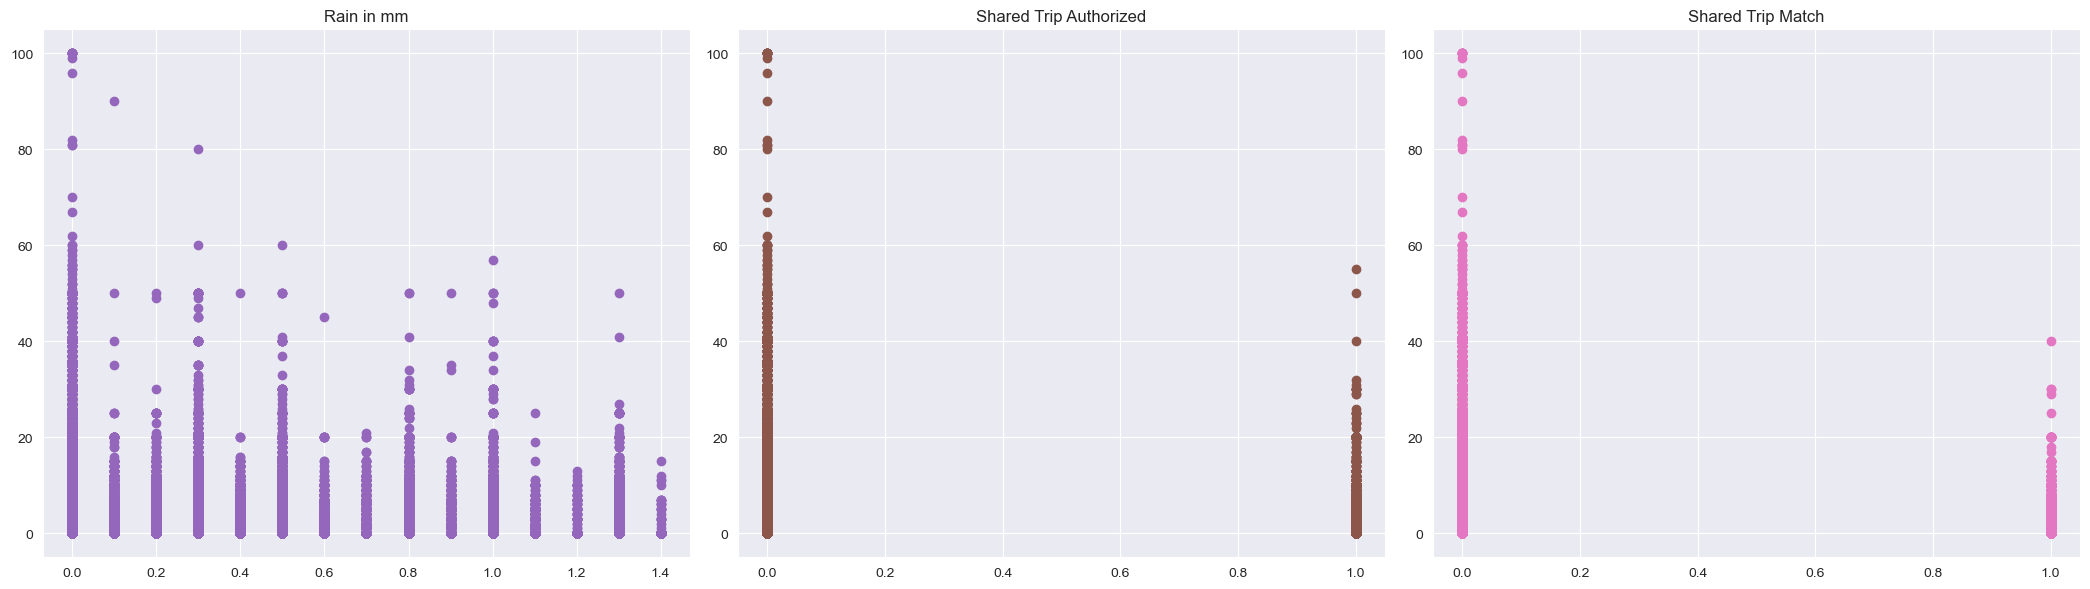

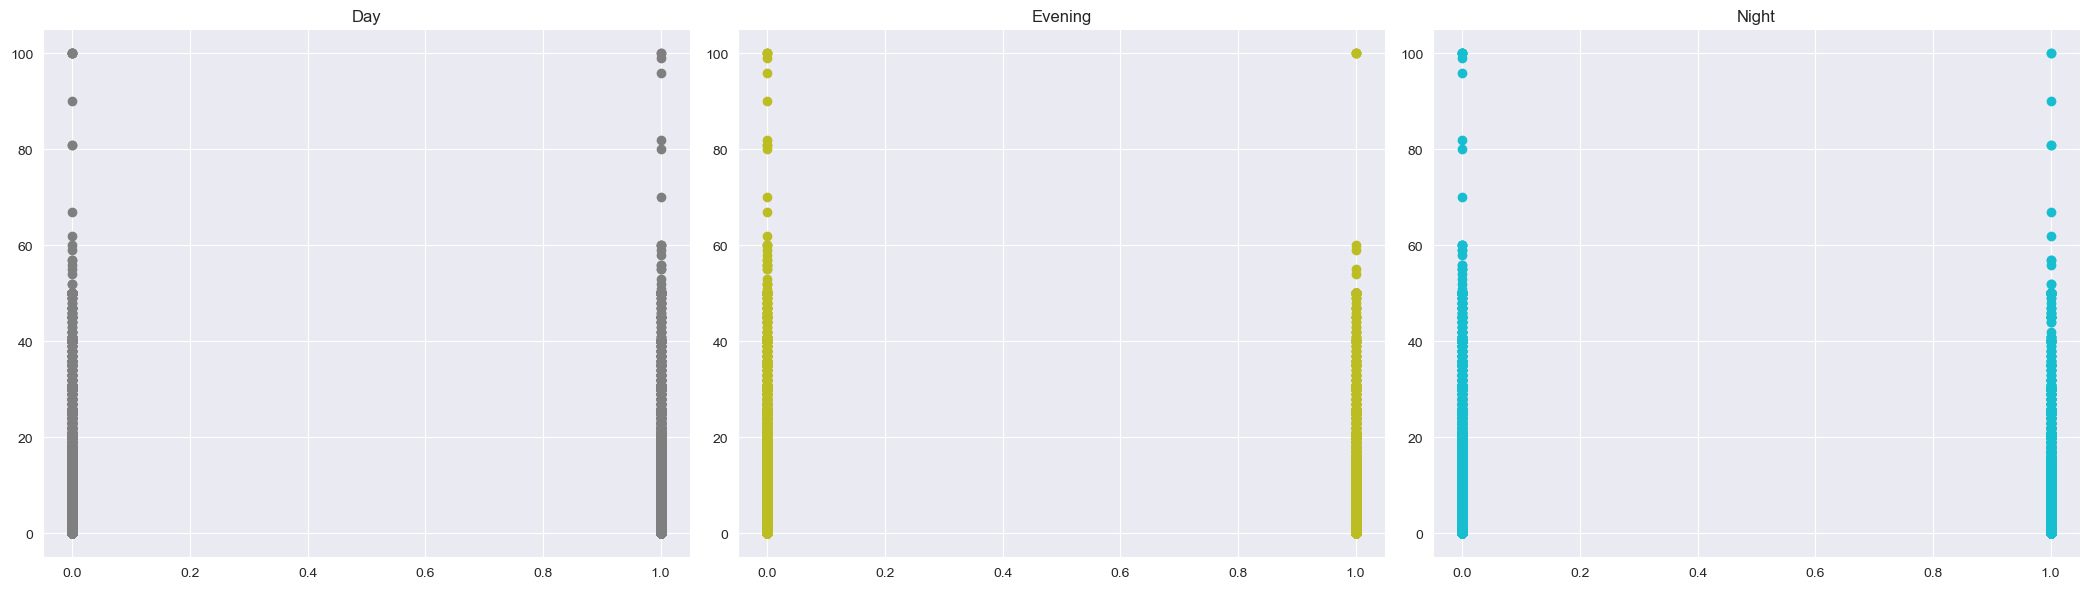

In [21]:
#Create Scatterplots for the first 4 predictors
fig_1, axes_1 = plt.subplots(nrows = 1, ncols = 4, figsize= (21,6))
fig_1.suptitle("Scatterplots of all predictors", fontsize=26)
for i, ax in enumerate(axes_1):
    ax.scatter(x = x_train_data.iloc[:, i], y = y_train_data, color = f'C{i}')
    ax.set_title(x_train_data.columns[i])
plt.tight_layout()
plt.show()

#Create Scatterplots for predictor 5-7
fig_2, axes_2 = plt.subplots(nrows = 1, ncols = 3, figsize= (21,6))
for i, ax in enumerate(axes_2):
    ax.scatter(x = x_train_data.iloc[:, i + 4], y = y_train_data, color = f'C{i + 4}')
    ax.set_title(x_train_data.columns[i + 4])
plt.tight_layout()
plt.show()

#Create Scatterplots for predictor 8-10
fig_3, axes_3 = plt.subplots(nrows = 1, ncols = 3, figsize= (21,6))
for i, ax in enumerate(axes_3):
    ax.scatter(x = x_train_data.iloc[:, i + 7], y = y_train_data, color = f'C{i + 7}')
    ax.set_title(x_train_data.columns[i + 7])
plt.tight_layout()
plt.show()

After plotting the data we get some interesting information. It looks like there are a lot of linear correlations for example between the trip total and the tip. Moreover it is noticeable that the predictors are on diffrent scales so we need to normalize them to get meaningful result in our regression later on.

In [4]:
#Select which Data to normalize (no Dummy Variables)
columns_to_normalize = ["Trip Seconds", "Trip Miles", "Cost", "Temperature", "Rain in mm"]


x_train_data_scaled = x_train_data.copy()
x_val_data_scaled = x_val_data.copy()
x_test_data_scaled = x_test_data.copy()


#Normalize data
scaler = StandardScaler()
x_train_data_scaled[columns_to_normalize] = scaler.fit_transform(x_train_data[columns_to_normalize])
#Hier nur noch transform verwenden, damit Mittelwert und Standardabweichung nicht neu berechnet werden
x_val_data_scaled[columns_to_normalize] = scaler.transform(x_val_data[columns_to_normalize])
x_test_data_scaled[columns_to_normalize] = scaler.transform(x_test_data[columns_to_normalize])


x_train_data_scaled.head()


,Trip Seconds,Trip Miles,Cost,Temperature,Rain in mm,Shared Trip Authorized,Shared Trip Match,Day,Evening,Night
15875614,-0.431790,-0.751874,-0.566920,-0.790412,-0.2975,0,0,1,0,0
9035578,-0.978755,-0.853494,-0.867470,1.249400,-0.2975,0,0,0,0,1
19475975,0.121765,-0.589283,-0.443392,-1.051319,-0.2975,0,0,1,0,0
12349447,-0.436732,-0.243777,-0.219681,-0.790412,-0.2975,0,0,0,0,1
10206167,2.798927,2.418653,2.744001,0.193916,-0.2975,0,0,1,0,0


<h4 style="text-decoration: underline;">3.x Linear Regression</h4>

After finishing the data preperation and completing our descripive task we now want to start with our predictive models. First of all we want to create an simple linear regression because we have seen a few linear relationships between our predictors and the tip in the descriptive task above. In the next steps we define our linear regression model which has the following input vector:
\begin{equation}
x^{(i)} = \left[ \begin{array}{c} 1 \\ \mathrm{Trip\ Seconds}^{(i)} \\ \mathrm{Trip\ Miles}^{(i)} \\ \mathrm{Shared\ Trip\ Authorized}^{(i)} \\ \mathrm{Shared\ Trip\ Matched}^{(i)} \\ \mathrm{Cost}^{(i)} \\ \mathrm{Temperature}^{(i)} \\ \mathrm{Rain\ in\ mm}^{(i)} \\ \mathrm{Night}^{(i)} \\ \mathrm{Day}^{(i)} \\
\mathrm{Evening}^{(i)} \end{array} \right] \end{equation}

In addition we create our linear hypothesis function $tip_\beta(x) = \beta^Tx$ is given by:

\begin{equation}
tip_\beta(x) = \beta_0 + \beta_1 * \mathrm{Trip\ Seconds}^{(i)} + \beta_2 * \mathrm{Trip\ Miles}^{(i)} + \beta_3 * \mathrm{Shared\ Trip\ Authorized}^{(i)} + \\ \beta_4 * \mathrm{Shared\ Trip\ Matched}^{(i)} + \beta_5 * \mathrm{Cost}^{(i)} + \beta_6 * \mathrm{Temperature}^{(i)} + \beta_7 * \mathrm{Rain\ In\ MM}^{(i)} + \\ \beta_8 * \mathrm{Night}^{(i)} + \beta_9 * \mathrm{Day}^{(i)} + \beta_{10} * \mathrm{Evening}^{(i)} 
\end{equation}

After defining our linear regression model, we now want to find the right values for our predictors $ \beta_0, \beta_1, \dots, \beta_9 $.


In [24]:
linear_model = LinearRegression()
linear_model.fit(x_train_data_scaled, y_train_data)
print("Values for our predictors:" + str(linear_model.coef_))

Values for our predictors:[-1.60136348e-01 -1.59998571e-01  9.92986071e-01  1.99782892e-02
 -5.72135357e-03 -3.37906199e-01  5.87213848e-02  9.03110284e+10
  9.03110284e+10  9.03110284e+10]


In [40]:
linear_model_prediction = linear_model.predict(x_test_data_scaled)
print("Mean absoulte Error:", round(mean_absolute_error(y_test_data, linear_model_prediction), 4), "R2:", round(r2_score(y_test_data, linear_model_prediction), 4))

Mean absoulte Error: 1.4423 R2: 0.1249


In [79]:
y = [x_test_data_scaled.iloc[18]]
print("Prediction: ", linear_model.predict(y), "Real value", y_test_data.iloc[18])


Prediction:  [1.5838623] Real value 5.0


<h4 style="text-decoration: underline;">3.x Radial Basis Function</h4>
As we can see our linear approach didn't worked that good so we need to try out another non linear approach. For this we want to make use of radial basis functions(RBF). Our problem is definied by:
\begin{equation}
 \begin{aligned}
x = \left[ \begin{array}{c} \mathrm{Trip\ Seconds} \\ \mathrm{Trip\ Miles} \\ \mathrm{Shared\ Trip\ Authorized} \\ \mathrm{Shared\ Trip\ Matched} \\ \mathrm{Cost} \\ \mathrm{Temperature} \\ \mathrm{Rain\ in\ mm} \\ \mathrm{Night} \\ \mathrm{Day} \\ \mathrm{Evening} \end{array} \right] 
\qquad
\phi = \left[ \begin{array}{c} 1 \\ \mathrm{x} \end{array} \right]
\end{aligned}
\end{equation}

Because our input vector $ x \in \mathbb{R}^9 $ we need to use mulit dimensional radial basis functions
 